In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import sys
import cv2
import matplotlib.pyplot as plt
import os
import imutils
from imutils import face_utils
import dlib
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dir_path = 'drive/My Drive/ML/'

sys.path.insert(0, dir_path)

from model import create_model

Using TensorFlow backend.


# Data Augmentation Script

In [0]:
## Data Augmentation script
"""
face_data_path = "drive/My Drive/ML/Dataset/"
tf.enable_eager_execution()

cnt = 0
for f in os.listdir(face_data_path):
    img_raw = tf.read_file(face_data_path+f)
    try:
        img_tensor = tf.image.decode_png(img_raw)
    except:
        continue
    if f.find("fliplr") != -1:
		    continue
    print(f)
#    fliplr = tf.image.flip_left_right(img_tensor)
#    flipud = tf.image.flip_up_down(img_tensor)
#    rotl = tf.contrib.image.rotate(img_tensor, angles=3.1415/4)
#    rotr = tf.contrib.image.rotate(img_tensor, angles=-3.1415/4)
##    fliplr_raw = tf.image.encode_png(fliplr)
##    flipud_raw = tf.image.encode_png(flipud)
    noise = tf.random_normal(shape=tf.shape(img_tensor), mean=0.0, stddev=1.0)
    noise_img = tf.add(img_tensor, tf.cast(noise,dtype=tf.uint8))
    
#    fliplr_raw = tf.image.encode_png(fliplr)
#    flipud_raw = tf.image.encode_png(flipud)
    rotl_raw = tf.image.encode_png(rotl)
    rotr_raw = tf.image.encode_png(rotr)
    noise_raw = tf.image.encode_png(noise_img)
    
#    tf.write_file(face_data_path+f.split(".")[0]+"_fliplr.png", fliplr_raw)
#    tf.write_file(face_data_path+f.split(".")[0]+"_flipud.png", flipud_raw)
#    tf.write_file(face_data_path+f.split(".")[0]+"_rotl.png", rotl_raw)
#    tf.write_file(face_data_path+f.split(".")[0]+"_rotr.png", rotr_raw)
    tf.write_file(face_data_path+f.split(".")[0]+"_noise.png", noise_raw)
    cnt += 1
print(cnt)
"""

'\nface_data_path = "drive/My Drive/ML/Dataset/"\ntf.enable_eager_execution()\n\ncnt = 0\nfor f in os.listdir(face_data_path):\n    img_raw = tf.read_file(face_data_path+f)\n    try:\n        img_tensor = tf.image.decode_png(img_raw)\n    except:\n        continue\n    if f.find("fliplr") != -1:\n\t\t    continue\n    print(f)\n#    fliplr = tf.image.flip_left_right(img_tensor)\n#    flipud = tf.image.flip_up_down(img_tensor)\n#    rotl = tf.contrib.image.rotate(img_tensor, angles=3.1415/4)\n#    rotr = tf.contrib.image.rotate(img_tensor, angles=-3.1415/4)\n##    fliplr_raw = tf.image.encode_png(fliplr)\n##    flipud_raw = tf.image.encode_png(flipud)\n    noise = tf.random_normal(shape=tf.shape(img_tensor), mean=0.0, stddev=1.0)\n    noise_img = tf.add(img_tensor, tf.cast(noise,dtype=tf.uint8))\n    \n#    fliplr_raw = tf.image.encode_png(fliplr)\n#    flipud_raw = tf.image.encode_png(flipud)\n    rotl_raw = tf.image.encode_png(rotl)\n    rotr_raw = tf.image.encode_png(rotr)\n    noise

In [0]:
# Load roll number dictionary
roll_dict = {'1641002': 0, '1641003': 1, '1641005': 2, '1641006': 3, '1641007': 4, '1641010': 5, '1641011': 6, '1641013': 7, 
             '1641014': 8, '1641015': 9, '1641016': 10, '1641017': 11, '1641020': 12, '1641021': 13, '1641023': 14, '1641025': 15, 
             '1641026': 16, '1641027': 17, '1641028': 18, '1641029': 19, '1641030': 20, '1641031': 21, '1641034': 22, '1641035': 23, 
             '1641036': 24, '1641038': 25, '1641039': 26, '1641040': 27, '1641043': 28, '1641044': 29, '1641046': 30, '1641047': 31, 
             '1641052': 32, '1641054': 33, '1641055': 34, '1641057': 35, '1641059': 36, '1641060': 37, '1641061': 38, '1641062': 39, 
             '1641065': 40, '1641066': 41, '1641067': 42, '1641068': 43, '1641069': 44, '1641071': 45, '1641072': 46, '1641073': 47, 
             '1844001': 48, '1844002': 49, '1844004': 51, '1844005': 52, '1844006': 53, '1844007': 54, '1844008': 55, '1844010': 56, 
             '1849007': 57, '1849011': 58, '1849012': 59, '1849013': 60, '201501103': 61, '1641045': 62}


In [0]:
proto_path = dir_path + 'deploy.prototxt.txt'
model_path = dir_path + 'res10_300x300_ssd_iter_140000.caffemodel'
predictor_path = dir_path + 'shape_predictor_68_face_landmarks.dat'

predictor = dlib.shape_predictor(predictor_path)
net = cv2.dnn.readNetFromCaffe(proto_path, model_path)
detector = dlib.get_frontal_face_detector()
fa = FaceAligner(predictor, desiredFaceWidth=96)

# Face Detection Functions

In [0]:
def detect_face_dl(image):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (start_x, start_y, end_x, end_y) = box.astype("int")
            y = (start_y - 10) if (start_y - 10) > 10 else (start_y + 10)
            rect = dlib.rectangle(left=int(start_x), top=int(start_y), right=int(end_x), bottom=int(end_y))
            image_centered = fa.align(image, gray, rect)
            
            return image_centered

In [0]:
def detect_face_dlib(image, gray, rects):
    for (i, rect) in enumerate(rects):
        centered_image = fa.align(image, gray, rect)
        return centered_image

In [0]:
def get_face(image):
  image_low_res = imutils.resize(image, width=800)
  gray = cv2.cvtColor(image_low_res, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 1)
  if len(rects) > 0:
    face = detect_face_dlib(image_low_res, gray, rects)
  else:
    face = detect_face_dl(image)
  return face

# Computing the Encoding vectors

In [0]:
model = create_model()
model.load_weights(dir_path + 'nn4.small2.v1.h5')

def get_encodings(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = (image / 255.).astype(np.float32)
  return model.predict(np.expand_dims(image, axis=0))[0]

# Loading Dataset
## Preparing X and Y

In [0]:
## Calculating encodings of each image
data_path = dir_path + 'faces/'
encoding_list = []
indices = []

for filename in os.listdir(data_path):
  img_path = data_path + filename
  image = cv2.imread(img_path)
  face = cv2.resize(image,(96,96))
  encodings = get_encodings(face)
  encoding_list.append(encodings)
  indices.append(roll_dict[filename.split('_')[0]])
  print(filename)

In [0]:
## Saving the encodings of the dataset
X = np.array(encoding_list)
a = np.array(indices)
b = np.zeros((X.shape[0],63))
b[np.arange(X.shape[0]), a] = 1
Y = b

np.save('face_recog_encodings', X)
np.save('face_recog_out_vector',Y)

print(X.shape)
print(Y.shape)

(5160, 128)
(5160, 63)


In [4]:
## Loading the dataset encodings
X = np.load(dir_path+'face_recog_encodings.npy')
Y = np.load(dir_path+'face_recog_out_vector.npy')

print("X shape = ", X.shape)
print("Y shape = ", Y.shape)

X shape =  (5160, 128)
Y shape =  (5160, 63)


# Train Test Split

In [5]:
sc = StandardScaler()

X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.20, random_state=42)
'''
X_train = X_train - np.mean(X_train, axis=0)
X_train = X_train / np.std(X_train, axis=0)
X_test = X_test - np.mean(X_test, axis=0)
X_test = X_test / np.std(X_test, axis=0)
'''
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

np.save(dir_path+'ms', np.array([sc.mean_, sc.scale_]))

print("X_train : ",X_train.shape)
print("X_test : ",X_test.shape)
print("Y_train : ", Y_train.shape)
print("Y_test : ",Y_test.shape)

X_train :  (4128, 128)
X_test :  (1032, 128)
Y_train :  (4128, 63)
Y_test :  (1032, 63)


# KERAS DNN

In [0]:
# Imports
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [0]:
classifier = Sequential()

classifier.add(Dense(units = 95, kernel_initializer = 'uniform', activation = 'relu', input_dim = 128))
classifier.add(Dropout(0.1))

classifier.add(Dense(units = 95, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.1))

classifier.add(Dense(units = 63, kernel_initializer = 'uniform', activation = 'softmax'))

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

classifier.fit(X_train, Y_train, batch_size = 16, epochs = 20)

score, acc = classifier.evaluate(X_test, Y_test, batch_size=16)
print('Test score : ', score)
print('Test accuracy achieved using Artificial Neural Network : ', acc)

Convert the one hot vectors to index values, which is supported in sklearn SVM and KNN.

In [0]:
Y_train_list = np.array([np.where(r==1)[0][0] for r in Y_train])
Y_test_list = np.array([np.where(r==1)[0][0] for r in Y_test])

# SKLEARN SVM

In [9]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
'''
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
'''
#Create a svm Classifier
param_grid = {'C': [1e3],
              'gamma': [0.01] }
svm_classifier = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)

#Train the model using the training sets
svm_classifier.fit(X_train, Y_train_list)
print(svm_classifier.best_estimator_)

#Predict the response for test dataset
y_pred = svm_classifier.predict(X_test)

svm_acc = accuracy_score(Y_test_list, y_pred)
print("Test accuracy achieved using SVM : " + str(svm_acc))

SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Test accuracy achieved using SVM : 0.9641472868217055


In [11]:
from sklearn.metrics import classification_report

target_names = roll_dict.keys()

print(classification_report(Y_test_list, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     1641002       1.00      1.00      1.00        17
     1641003       1.00      1.00      1.00        10
     1641005       0.76      0.87      0.81        15
     1641006       0.89      1.00      0.94        16
     1641007       1.00      0.89      0.94        19
     1641010       0.80      1.00      0.89         8
     1641011       0.95      0.90      0.92        20
     1641013       1.00      1.00      1.00        16
     1641014       1.00      0.88      0.93        16
     1641015       1.00      1.00      1.00        18
     1641016       1.00      1.00      1.00        15
     1641017       1.00      1.00      1.00        21
     1641020       1.00      1.00      1.00        21
     1641021       0.88      1.00      0.94        15
     1641023       0.94      1.00      0.97        17
     1641025       0.83      1.00      0.91        20
     1641026       1.00      1.00      1.00        19
     1641027       0.86    

# SKLEARN KNN

In [0]:
from sklearn import neighbors, datasets
from sklearn.metrics import accuracy_score

n_neighbors = 3

knn_classifier = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knn_classifier.fit(X_train, Y_train_list)
knn_pred = knn_classifier.predict(X_test)


knn_acc = accuracy_score(Y_test_list, knn_pred)
print("Test Accuracy achieved using KNN : " + str(knn_acc))

Test Accuracy achieved using KNN : 0.9156976744186046


# Testing

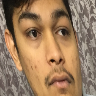

[3]


In [0]:
from google.colab.patches import cv2_imshow


test_image_path = 'drive/My Drive/ML/test/het.jpg'
image = cv2.imread(test_image_path)
face = get_face(image)
cv2_imshow(face)
encodings = get_encodings(face)
encodings = encodings.reshape(1,128)

prediction = svm_classifier.predict(sc.transform(encodings))

print(prediction)
#print(np.argmax(prediction))

#Saving the trained models

In [0]:
from keras.models import load_model
from joblib import dump, load

dump(svm_classifier, 'face_recog_svm_clf.joblib') 
dump(knn_classifier, 'face_recog_knn_clf.joblib') 

#clf = load('filename.joblib') 

classifier.save('face_recog_ann_clf.h5') 
#clf = load_model('face_recog_ann_clf.h5')